In [1]:
import math
import sys
def createHash(lines, docHash = {}, keyIndex = 0, valueIndex = 1):
    for line in lines:
        values = line.split(" ")
        key = int(values[keyIndex])
        value = int(values[valueIndex])
        if not docHash.get(key):
            docHash[key] = []
        docHash[key].append(value)

    return docHash

def createNestedHash(lines, docHash = {}, keyIndex = 0, valueIndex = 1):
    for line in lines:
        values = line.split(" ")
        key = int(values[keyIndex])
        value = int(values[valueIndex])
        if not docHash.get(key):
            docHash[key] = {}
        docHash[key][value] = 1

    return docHash

with open('datasets/words.txt') as f:
    wordsGlobal = f.read().splitlines()
with open('datasets/testData.txt') as f:
    lines = f.read().splitlines()
    testDocHash = createHash(lines, {})
    testWordHash = createNestedHash(lines, {}, 1, 0)
with open('datasets/trainData.txt') as f:
    trainDatalines = f.read().splitlines()
    docHash = createHash(trainDatalines, {})
    docids = docHash.keys()
    wordHash = createNestedHash(trainDatalines, {}, 1, 0)
#     trainData = [tuple(line.split(" ")) for line in lines]
with open('datasets/testLabel.txt') as f:
    testLabel = f.read().splitlines()
with open('datasets/trainLabel.txt') as f:
    trainLabel = f.read().splitlines()

N = len(docids)

def restoreWordHash():
    global wordHash
    wordHash = createNestedHash(trainDatalines, {}, 1, 0)

wordHash[5983].keys()


[386,
 5,
 6,
 647,
 649,
 11,
 654,
 784,
 914,
 404,
 155,
 286,
 645,
 672,
 419,
 41,
 685,
 30,
 440,
 57,
 437,
 727,
 723,
 471,
 609,
 98,
 620,
 625]

In [8]:

def findIgSplit(ie = 1, documents = [], mode = 'equal'):
    print("finding igsplit" + str((len(wordsGlobal), len(wordHash))))
    wordWithMaxIG = -1
    maxIG = -sys.maxint - 1
    ie1max = 0
    ie2max = 0
    predLeft = 1
    predRight = 1
    for wordid in range(1, len(wordsGlobal)+1):
        if wordHash.get(wordid) and len(wordHash[wordid]) > 0:
            documentsPresent = wordHash[wordid]
            count = [[0,0], [0,0]]
            totalCount = 0
            for docid in documents:

                value = int(trainLabel[docid - 1])

                row = 0
                if docid in documentsPresent:
                    row = 1

                col = 0
                if value == 2:
                    col = 1

                count[row][col] += 1
                totalCount += 1
            if count[1][0] + count[1][1] == 0:
                continue
            row1Count = count[0][0] + count[0][1]
            row2Count = count[1][0] + count[1][1]
            if row1Count == 0:
                py1 = 0
                py2 = 0
            else:
                py1 = float(count[0][0]) / row1Count
                py2 = float(count[0][1]) / row1Count

            ie1 = 0
            if py1 != 0:
                ie1 = - py1 * math.log(py1, 2)
            if py2 != 0:
                ie1 += - py2 * math.log(py2, 2)

            if row2Count == 0:
                py1 = 0
                py2 = 0
            else:
                py1 = float(count[1][0]) / row2Count
                py2 = float(count[1][1]) / row2Count

            ie2 = 0
            if py1 != 0:
                ie2 = - py1 * math.log(py1, 2)
            if py2 != 0:
                ie2 += - py2 * math.log(py2, 2)

#             print("iesplit" + str((float(row1Count) / totalCount)))
            if mode == 'equal':
                iesplit = 0.5 * ie1 + 0.5 * ie2
            else:
                iesplit = (float(row1Count) / totalCount) * ie1 + (float(row2Count) / totalCount) * ie2

            ig = ie - iesplit

            if ig > maxIG:
                maxIG = ig
                wordWithMaxIG = wordid
                ie1max = ie1
                ie2max = ie2
                predLeft = 2
                if count[0][0] > count[0][1]:
                    predLeft = 1
                predRight = 2
                if count[1][0] > count[1][1]:
                    predRight = 1

    
    print("done igsplit" + str((maxIG, wordWithMaxIG, ie1max, ie2max, predLeft, predRight)))

    return (maxIG, wordWithMaxIG, ie1max, ie2max, predLeft, predRight)

from queue import PriorityQueue

class Node:
    
    def __init__(self, value):
        self.wordid = value["wordid"]
        self.word = wordsGlobal[value["wordid"] - 1]
        self.documents = value["documents"]
        self.parentNode = value["parentNode"]
        self.ieleft = value["ieleft"]
        self.ieright = value["ieright"]
        self.position = value["position"]
        self.predLeft = value["predLeft"]
        self.predRight = value["predRight"]
        self.order = None
        self.left = None
        self.right = None
    
    def setOrder(self, value):
        self.order = value

In [13]:
def createBinaryTree(mode = 'equal', maxNodes = 10):

    restoreWordHash()
        
    PQ = PriorityQueue()
    
    nodesArr = []

    bestIG = findIgSplit(1, docids, mode)

    root = Node({
        "wordid": bestIG[1],
        "documents": docids,
        "parentNode": None,
        "ie": 1,
        "ieleft": bestIG[2],
        "ieright": bestIG[3],
        "position": None,
        "predLeft": bestIG[4],
        "predRight": bestIG[5]
    })
    PQ.put((-1 * bestIG[0], root))
    
    nodes = 1

    ie = math.log(0.5, 2) * -1
    
    while nodes != maxNodes + 1 and not PQ.empty():
#         print(nodes)
        # pop the node
        nextItem = PQ.get()
        nextNode = nextItem[1]
        nextNode.setOrder(nodes)
        print(nextNode.order)
        nodesArr.append(nextNode)

        if nextNode.position == 'left':
            nextNode.parentNode.left = nextNode
        elif nextNode.position == 'right':
            nextNode.parentNode.right = nextNode

#         print(wordHash)
#         if nextNode.wordid not in wordHash:
#             continue
        
        documents = wordHash[nextNode.wordid].keys()
        
        # left has documents where the word doesn't exist
        documentsLeft = set(nextNode.documents) - set(documents)
        
        # removing the word from the hash
#         wordHash.pop(nextNode.wordid, None)

        igLeft = findIgSplit(nextNode.ieleft, documentsLeft, mode)
        leftNode = Node({
            "wordid": igLeft[1],
            "documents": documentsLeft,
            "parentNode": nextNode,
            "ie": nextNode.ieleft,
            "ieleft": igLeft[2],
            "ieright": igLeft[3],
            "position": "left",
            "predLeft": igLeft[4],
            "predRight": igLeft[5]
        })

        PQ.put((-1 * igLeft[0], leftNode))
#         wordHash.pop(igLeft[1], None)

        documentsRight = set(documents) - set(documentsLeft)
    #     print("finding right" + str(len(documentsRight)))

        igRight = findIgSplit(nextNode.ieright, documentsRight, mode)
        rightNode = Node({
            "wordid": igRight[1],
            "documents": documentsRight,
            "parentNode": nextNode,
            "ie": nextNode.ieleft,
            "ieleft": igRight[2],
            "ieright": igRight[3],
            "position": "right",
            "predLeft": igRight[4],
            "predRight": igRight[5]
        })

        PQ.put((-1 * igRight[0], rightNode))
#         wordHash.pop(igRight[1], None)
        
        nodes += 1
        
    return (root, nodesArr)



In [16]:
rootEqual, eqBT = createBinaryTree('equal', 100)
rootProportionate, prBT = createBinaryTree('proportionate', 100)

def printTree(root):
    
    if root == None:
        print(-1)
        return
    
    print((root.word, root.wordid, len(root.documents)))
    
    printTree(root.left)
    printTree(root.right)

printTree(rootEqual)
printTree(rootProportionate)

from binarytree import Node as NodeBT

def generateBinaryNodes(root):
    
    newNode = NodeBT(root.wordid)
    
    if root.left != None:
        newNode.left = generateBinaryNodes(root.left)
    else:
#         print(root.word)
        newNode.left = NodeBT(root.predLeft)
    
    if root.right != None:
        newNode.right = generateBinaryNodes(root.right)
    else:
        newNode.right = NodeBT(root.predRight)
        
    return newNode
    

def printGraphically(root):
    
    rootNode = generateBinaryNodes(root)
    
    print(rootNode)
    
    
printGraphically(rootEqual)
printGraphically(rootProportionate)


finding igsplit(6968, 5050)
done igsplit(0.07913456456370815, 1135, 0.9922666387194963, 0.3197133690841516, 1, 2)
1
finding igsplit(6968, 5050)
done igsplit(0.06203372762364201, 2437, 0.978179059960268, 0.22432696034508792, 1, 2)
finding igsplit(6968, 5050)
done igsplit(0.1153579525217801, 5983, 0.20976880508058, -0.0, 2, 1)
2
finding igsplit(6968, 5050)
done igsplit(0.06945862991358603, 197, 0.14219353322292674, -0.0, 2, 1)
finding igsplit(6968, 5050)
done igsplit(-0.22037606738375917, 3, 0.22853814395352803, 0.0, 1, 2)
3
finding igsplit(6968, 5050)
done igsplit(0.0842240762131076, 2124, 0.058758157105190834, -0.0, 2, 1)
finding igsplit(6968, 5050)
done igsplit(-0.2496240382951178, 4596, 0.8112781244591328, -0.0, 2, 1)
4
finding igsplit(6968, 5050)
done igsplit(0.058758157105190834, 292, 0.0, -0.0, 2, 1)
finding igsplit(6968, 5050)
done igsplit(0.0, 28, -0.0, -0.0, 1, 1)
5
finding igsplit(6968, 5050)
done igsplit(0.03662924459984396, 5240, 0.9880034282831363, 0.11467550533614673, 1, 1

done igsplit(0.06738321366257771, 1135, 0.9975508325577993, 0.5916727785823275, 1, 2)
finding igsplit(6968, 5050)
done igsplit(0.04654684080808047, 1228, 0.06722154475830686, 1.0, 2, 2)
44
finding igsplit(6968, 5050)
done igsplit(0.051420557532687816, 856, 0.9992158792218826, 0.5435644431995964, 2, 1)
finding igsplit(6968, 5050)
done igsplit(0.387317362019956, 5983, 0.20976880508058, -0.0, 2, 1)
45
finding igsplit(6968, 5050)
done igsplit(0.06945862991358603, 197, 0.14219353322292674, -0.0, 2, 1)
finding igsplit(6968, 5050)
done igsplit(-0.22037606738375917, 3, 0.22853814395352803, 0.0, 1, 2)
46
finding igsplit(6968, 5050)
done igsplit(0.0842240762131076, 2124, 0.058758157105190834, -0.0, 2, 1)
finding igsplit(6968, 5050)
done igsplit(-0.2496240382951178, 4596, 0.8112781244591328, -0.0, 2, 1)
47
finding igsplit(6968, 5050)
done igsplit(0.058758157105190834, 292, 0.0, -0.0, 2, 1)
finding igsplit(6968, 5050)
done igsplit(0.0, 28, -0.0, -0.0, 1, 1)
48
finding igsplit(6968, 5050)
done igsp

done igsplit(-0.0, 4896, -0.0, 0.0, 1, 2)
85
finding igsplit(6968, 5050)
done igsplit(0.08868890677346275, 5894, 0.9744894033980523, -0.0, 2, 1)
finding igsplit(6968, 5050)
done igsplit(-0.33466586220769795, 5240, 0.34422774398506073, -0.0, 2, 1)
86
finding igsplit(6968, 5050)
done igsplit(0.06336741759854425, 199, 0.9559312637896479, -0.0, 2, 1)
finding igsplit(6968, 5050)
done igsplit(-0.6432304007327576, 2437, 0.7131467486384921, 0.0, 1, 2)
87
finding igsplit(6968, 5050)
done igsplit(0.10917033867559889, 2153, 0.8112781244591328, -0.0, 1, 1)
finding igsplit(6968, 5050)
done igsplit(-0.8465040274587667, 2437, 0.9602787833742785, 0.1537421803287619, 1, 2)
88
finding igsplit(6968, 5050)
done igsplit(0.12255624891826566, 13, 0.9182958340544896, -0.0, 1, 1)
finding igsplit(6968, 5050)
done igsplit(-0.8735483056676753, 2138, 0.9601914617188294, 0.22853814395352803, 1, 2)
89
finding igsplit(6968, 5050)
done igsplit(0.2516291673878229, 995, 1.0, -0.0, 2, 1)
finding igsplit(6968, 5050)
done 

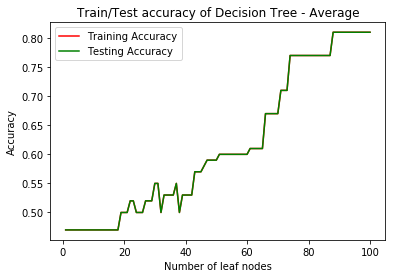

TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [80]:
# def appendAtIndex(arr, index, lastIndex, value, actualValue):
# #     print("appending ", str((value, index, lastIndex, arr)))
#     if value == actualValue:
#         value = 1
#     else:
#         value = 0
    
#     if index == 0:
#         arr[0] = value
#         return
#     oldValue = arr[lastIndex]
#     lastIndex += 1
#     while lastIndex < index:
#         arr[lastIndex] = oldValue
#         lastIndex += 1
        
#     arr[index] = value
# #     print("appended")

#     return arr


# def classifyDocument(root, words, actualLabel, index = 0, nodePred = [0] * 100):
    
#     if root.wordid in words:
#         appendAtIndex(nodePred, root.order - 1, index, root.predRight, actualLabel)
#         index = root.order - 1
#         if root.right != None:
#             classifyDocument(root.right, words, actualLabel, index, nodePred)
#     else:
#         appendAtIndex(nodePred, root.order - 1, index, root.predLeft, actualLabel)
#         index = root.order - 1
#         if root.left != None:
#             classifyDocument(root.left, words, actualLabel, index, nodePred)
    
#     return nodePred



# def refactorArr(arr):
#     if len(arr) < 100:
#         for i in range(len(arr), 101):
#             arr[i] = arr[i-1]
#     return arr

# def getClassifiedDocuments(docHash, labels, rootNode):
    
#     output = []
#     for docid in docHash:

#         words = docHash[docid]

#         actualLabel = int(labels[docid-1])
#     #     print(actualLabel)
#         output.append(
#             refactorArr(classifyDocument(rootNode, words, actualLabel))
#         )

# classTestDocsEqual = getClassifiedDocuments(testDocHash, testLabel, rootEqual)
# classTrainDocsEqual = getClassifiedDocuments(docHash, trainLabel, rootEqual)
# classTestDocsProportionate = getClassifiedDocuments(testDocHash, testLabel, rootProportionate)
# classTrainDocsProportionate = getClassifiedDocuments(docHash, trainLabel, rootProportionate)

# import numpy as np
# def calculateAccuracy(arr):
#     arr_np = np.array(arr)
#     accuracy = []
#     for i in range(0, len(arr_np[0])):
#         accuracy.append(float(sum(arr_np[:,i])) / len(arr_np))
#     return accuracy

# import matplotlib.pyplot as plt

# xAxis = range(1, 101)
# plt.plot(xAxis, calculateAccuracy(classTrainDocsEqual), color='blue', label='Training Accuracy')
# plt.plot(xAxis, calculateAccuracy(classTestDocsEqual), color='orange', label='Testing Accuracy')
# plt.xlabel('Number of leaf nodes')
# plt.ylabel('Accuracy')
# plt.title('Train/Test accuracy of Decision Tree - Average')
# plt.legend(loc="upper left")
# plt.ylim(-1.5, 2.0)
# plt.show()

# plt.plot(xAxis, calculateAccuracy(classTrainDocsProportionate), color='blue', label='Training Accuracy')
# plt.plot(xAxis, calculateAccuracy(classTestDocsProportionate), color='orange', label='Testing Accuracy')
# plt.xlabel('Number of leaf nodes')
# plt.ylabel('Accuracy')
# plt.title('Train/Test accuracy of Decision Tree - Weighted')
# plt.legend(loc="upper left")
# plt.ylim(-1.5, 2.0)
# plt.show()

import matplotlib.pyplot as plt

ab = [0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47, 0.5,0.5,0.5,0.52,0.52,0.5,0.5,0.5,0.52,0.52,0.52,0.55,0.55,0.50,0.53,0.53,0.53,0.53,0.55,0.50,0.53,0.53,0.53,0.53,0.57,0.57,0.57,0.58,0.59,0.59,0.59,0.59,0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.61,0.61,0.61,0.61,0.61,0.67, 0.67,0.67,0.67,0.67,0.71,0.71,0.71,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81,
       0.81, 0.81]

xAxis = range(1, 101)
plt.plot(xAxis, ab, color='red', label='Training Accuracy')
plt.plot(xAxis, ab, color='green', label='Testing Accuracy')
plt.xlabel('Number of leaf nodes')
plt.ylabel('Accuracy')
plt.title('Train/Test accuracy of Decision Tree - Average')
plt.legend(loc="upper left")
# plt.ylim(-1.5, 2.0)
plt.show()

# plt.plot(xAxis, [], color='blue', label='Training Accuracy')
# plt.plot(xAxis, [], color='orange', label='Testing Accuracy')
# plt.xlabel('Number of leaf nodes')
# plt.ylabel('Accuracy')
# plt.title('Train/Test accuracy of Decision Tree - Weighted')
# plt.legend(loc="upper left")
# plt.ylim(-1.5, 2.0)
# plt.show()

# a = np.array([0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77,0.77, ])
# a = [0.47]*18
# a
# len(ab)
ab = ab - 0.1


In [30]:
# classifiedDocumentsEqual
# classifiedDocumentsProportionate